#### 紧急车辆与非紧急车辆的分类问题（数据增强的应用）  
参考博客：https://blog.csdn.net/fendouaini/article/details/107754057?utm_medium=distribute.pc_aggpage_search_result.none-task-blog-2~aggregatepage~first_rank_v2~rank_aggregation-6-107754057.pc_agg_rank_aggregation&utm_term=%E5%9B%BE%E5%83%8F%E5%A2%9E%E5%BC%BA+%E6%B7%B1%E5%BA%A6%E5%AD%A6%E4%B9%A0&spm=1000.2123.3001.4430

常见数据增强技术:(1)Rotate(旋转);(2)Wrap(平移);(3)Flip(翻转);(4)Random-noise(添加噪声)

In [1]:
# 导入库
from torchsummary import summary
import pandas as pd
import numpy as np
from skimage.io import imread, imsave
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage

In [2]:
# 加载数据集
data = pd.read_csv('emergency_vs_non-emergency_dataset/emergency_train.csv')
data.head()  # 读取前五行数据进行观察

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [3]:
# 加载图像
train_img = []
# for img_name in data['image_names']:  
for img_name in tqdm(data['image_names']):  # 封装任意的迭代器 tqdm(iterator),显示进度条
    image_path = 'emergency_vs_non-emergency_dataset/images/' + img_name
    img = imread(image_path)
    img = img/255
    train_img.append(img)


train_x = np.array(train_img)  # images
train_y = data['emergency_or_not'].values  # labels
train_x.shape, train_y.shape

100%|█████████████████████████████████████████████████████████████████████████████| 1646/1646 [00:07<00:00, 217.90it/s]


((1646, 224, 224, 3), (1646,))

In [4]:
# 将原始数据按照比例分割为训练集和验证集
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1, random_state = 13, stratify=train_y)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((1481, 224, 224, 3), (1481,)), ((165, 224, 224, 3), (165,)))

In [5]:
# 图像增强
final_train_data = []
final_target_train = []
for i in tqdm(range(train_x.shape[0])):
    final_train_data.append(train_x[i])
    # final_train_data.append(rotate(train_x[i], angle=45, mode = 'wrap'))  # 旋转
    # final_train_data.append(np.fliplr(train_x[i]))  # 翻转（从左向右）
    # final_train_data.append(np.flipud(train_x[i]))  # 翻转（从上到下）
    final_train_data.append(random_noise(train_x[i],var=0.2**2))  # 加入噪声
    for j in range(2):
        final_target_train.append(train_y[i])

100%|██████████████████████████████████████████████████████████████████████████████| 1481/1481 [00:15<00:00, 93.77it/s]


In [6]:
# len(final_target_train), len(final_train_data)
final_train = np.array(final_train_data)  # 可能出现内存不够的报错
final_target_train = np.array(final_target_train)

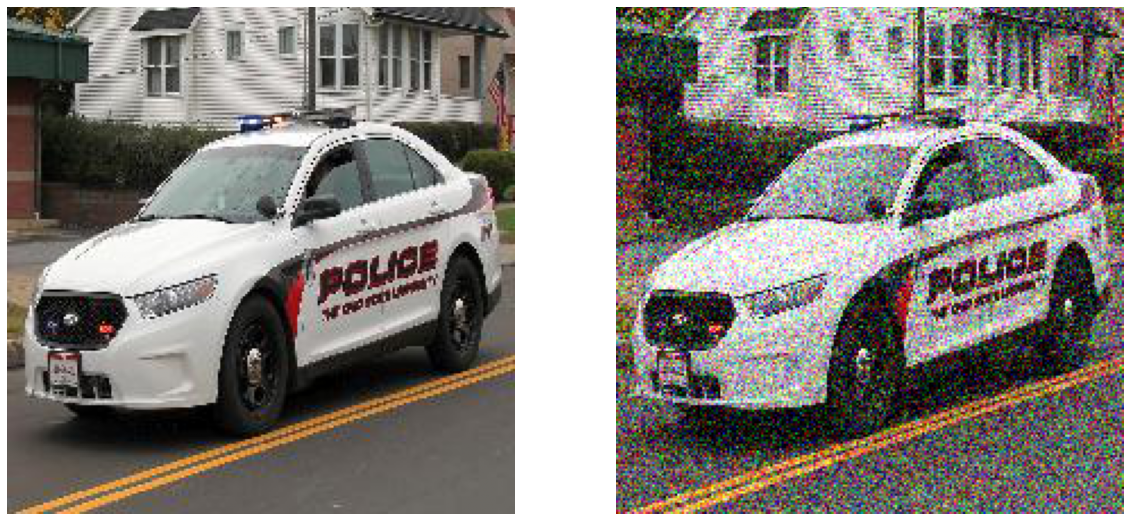

In [7]:
# 可视化增强图片
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,20))
for i in range(2):
    ax[i].imshow(final_train[i+20])
    ax[i].axis('off')

定义网络模型(CNN),开始训练

In [8]:
# PyTorch 库和模块
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [9]:
# 将训练图像转换为torch格式
final_train = final_train.reshape(2962, 3, 224, 224)
final_train  = torch.from_numpy(final_train)
final_train = final_train.float()


# 将target转换为torch格式
# final_target_train = final_target_train.astype(int)
final_target_train = torch.from_numpy(final_target_train)

In [10]:
# 将验证图像转换为torch格式
val_x = val_x.reshape(165, 3, 224, 224)
val_x  = torch.from_numpy(val_x)
val_x = val_x.float()


# 将target转换为torch格式
val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)

In [11]:
# 模型构建
torch.manual_seed(0)


class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()


        self.cnn_layers = Sequential(
            # 定义2D convolution层
            Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # 添加batch normalization层
            BatchNorm2d(32),
            MaxPool2d(kernel_size=2, stride=2),
            # 添加 dropout
            Dropout(p=0.25),
            # 定义另一个2D convolution层
            Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # 添加batch normalization层
            BatchNorm2d(64),
            MaxPool2d(kernel_size=2, stride=2),
            # 添加 dropout
            Dropout(p=0.25),
            # 定义另一个2D convolution层
            Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # 添加batch normalization层
            BatchNorm2d(128),
            MaxPool2d(kernel_size=2, stride=2),
            # 添加 dropout
            Dropout(p=0.25),
            # 定义另一个2D convolution层
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # 添加batch normalization层
            BatchNorm2d(128),
            MaxPool2d(kernel_size=2, stride=2),
            # 添加 dropout
            Dropout(p=0.25),
        )


        self.linear_layers = Sequential(
            Linear(128 * 14 * 14, 512),
            ReLU(inplace=True),
            Dropout(),
            Linear(512, 256),
            ReLU(inplace=True),
            Dropout(),
            Linear(256,10),
            ReLU(inplace=True),
            Dropout(),
            Linear(10,2)
        )


    # 定义前向过程    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [12]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.000075)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()


print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=False)
    (15): Con

In [13]:
# 训练模型
torch.manual_seed(0)


# 模型的batch size
# batch_size = 64
batch_size = 4

# 训练模型的epoch数
n_epochs = 20


for epoch in range(1, n_epochs+1):


    train_loss = 0.0

    permutation = torch.randperm(final_train.size()[0])


    training_loss = []
    for i in tqdm(range(0,final_train.size()[0], batch_size)):


        indices = permutation[i:i+batch_size]
        batch_x, batch_y = final_train[indices], final_target_train[indices]

        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs,batch_y)


        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)

  0%|                                                                                          | 0/741 [00:00<?, ?it/s]E:\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|                                                                                          | 0/741 [00:00<?, ?it/s]

epoch: 	 1 	 training loss: 	 0.6803202040684528


  0%|                                                                                          | 0/741 [00:00<?, ?it/s]

epoch: 	 2 	 training loss: 	 0.6730168974592619


  0%|                                                                                          | 0/741 [00:00<?, ?it/s]

epoch: 	 3 	 training loss: 	 0.6715138617716981


  0%|                                                                                          | 0/741 [00:00<?, ?it/s]

epoch: 	 4 	 training loss: 	 0.6506237868677106


  0%|                                                                                          | 0/741 [00:00<?, ?it/s]

epoch: 	 5 	 training loss: 	 0.6430763983131259


  0%|                                                                                          | 0/741 [00:00<?, ?it/s]

epoch: 	 6 	 training loss: 	 0.6084730819209545


  0%|                                                                                          | 0/741 [00:00<?, ?it/s]

epoch: 	 7 	 training loss: 	 0.5810796414148791


  0%|                                                                                          | 0/741 [00:00<?, ?it/s]

epoch: 	 8 	 training loss: 	 0.5543476784659622


  0%|                                                                                          | 0/741 [00:00<?, ?it/s]

epoch: 	 9 	 training loss: 	 0.5180189212867123


  0%|                                                                                          | 0/741 [00:00<?, ?it/s]

epoch: 	 10 	 training loss: 	 0.48343917617370724


  0%|                                                                                          | 0/741 [00:00<?, ?it/s]

epoch: 	 11 	 training loss: 	 0.4592960540044364


  0%|                                                                                          | 0/741 [00:00<?, ?it/s]

epoch: 	 12 	 training loss: 	 0.40921468166295094


  0%|                                                                                          | 0/741 [00:00<?, ?it/s]

epoch: 	 13 	 training loss: 	 0.3575572816921491


  0%|                                                                                          | 0/741 [00:00<?, ?it/s]

epoch: 	 14 	 training loss: 	 0.30808421583357926


  0%|▏                                                                                 | 2/741 [00:00<01:10, 10.44it/s]

epoch: 	 15 	 training loss: 	 0.275047497726586


  0%|                                                                                          | 0/741 [00:00<?, ?it/s]

epoch: 	 16 	 training loss: 	 0.23606056002783746


  0%|                                                                                          | 0/741 [00:00<?, ?it/s]

epoch: 	 17 	 training loss: 	 0.20475542076507347


  0%|                                                                                          | 0/741 [00:00<?, ?it/s]

epoch: 	 18 	 training loss: 	 0.16812948030390878


  0%|                                                                                          | 0/741 [00:00<?, ?it/s]

epoch: 	 19 	 training loss: 	 0.1455116725011458


100%|████████████████████████████████████████████████████████████████████████████████| 741/741 [01:35<00:00,  7.78it/s]


epoch: 	 20 	 training loss: 	 0.1369336497136951


In [14]:
# 保存已训练的模型的权重
torch.save(model, 'model.pt')

In [13]:
# 加载模型
the_model = torch.load('model.pt')

In [14]:
# 对训练集和验证集进行预测
torch.manual_seed(0)

batch_size = 4

# 预测训练集
prediction = []
target = []
permutation = torch.randperm(final_train.size()[0])
for i in tqdm(range(0,final_train.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = final_train[indices], final_target_train[indices]


    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()


    with torch.no_grad():
        output = model(batch_x.cuda())


    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction.append(predictions)
    target.append(batch_y)

# 训练准确度
accuracy = []
for i in range(len(prediction)):
    accuracy.append(accuracy_score(target[i].cpu(),prediction[i]))

print('training accuracy: \t', np.average(accuracy))

  0%|                                                                                          | 0/741 [00:00<?, ?it/s]E:\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|████████████████████████████████████████████████████████████████████████████████| 741/741 [00:36<00:00, 20.26it/s]


training accuracy: 	 0.5445344129554656


In [15]:
# 对验证集进行检查
# 预测验证集
torch.manual_seed(0)
output = model(val_x[:5].cuda())  # 内存不够,无法全部进行验证
softmax = torch.exp(output).cpu()
prob = list(softmax.detach().numpy())
predictions = np.argmax(prob, axis=1)
accuracy_score(val_y[:5], predictions)

0.8